# Evaluation of the model under different SNR values

In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchnet.meter as tnt
import importlib

from scipy.io.wavfile import write
import IPython

sys.path.append('../')
sys.path.append('../datasets')
sys.path.append(os.path.join(os.getcwd(), '../models/'))

import ai8x
from kws20_d import KWS
import kws20_d

In [2]:
data_path = '/home/emretopcu/ai8x-training/data'

class Args:
    def __init__(self, act_mode_8bit):
        self.act_mode_8bit = act_mode_8bit
        self.truncate_testset = False

simulate = False
args = Args(act_mode_8bit=simulate)

_ ,test_set = kws20_d.KWS_20_get_datasets((data_path, args), load_train=False, load_test=True)

Exception ignored in: <_io.FileIO name=65 mode='rb' closefd=True>
Traceback (most recent call last):
  File "/home/emretopcu/ai8x-training/venv/lib/python3.8/site-packages/audioread/__init__.py", line 99, in available_backends
    if ffdec.available():
Exception ignored in: <_io.FileIO name=67 mode='rb' closefd=True>
Traceback (most recent call last):
  File "/home/emretopcu/ai8x-training/venv/lib/python3.8/site-packages/audioread/__init__.py", line 99, in available_backends
    if ffdec.available():


No key `stretch` in input augmentation dictionary! Using defaults: [Min: 0.8, Max: 1.3]
Processing the label: backward. 1 of 36
Finished in 0.357 seconds.
Processing the label: bed. 2 of 36
Finished in 0.334 seconds.
Processing the label: bird. 3 of 36
Finished in 0.341 seconds.
Processing the label: cat. 4 of 36
Finished in 0.336 seconds.
Processing the label: dog. 5 of 36
Finished in 0.352 seconds.
Processing the label: down. 6 of 36
Finished in 0.649 seconds.
Processing the label: eight. 7 of 36
Finished in 0.629 seconds.
Processing the label: five. 8 of 36
Finished in 0.637 seconds.
Processing the label: follow. 9 of 36
Finished in 0.249 seconds.
Processing the label: forward. 10 of 36
Finished in 0.249 seconds.
Processing the label: four. 11 of 36
Finished in 0.601 seconds.
Processing the label: go. 12 of 36
Finished in 0.640 seconds.
Processing the label: happy. 13 of 36
Finished in 0.336 seconds.
Processing the label: house. 14 of 36
Finished in 0.347 seconds.
Processing the lab

In [3]:
classes = ['up', 'down', 'left', 'right', 'stop', 'go', 'yes', 'no', 'on', 'off', 'one',
                   'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'zero',
                   'UNKNOWN']

In [4]:
print("Number of samples in the test dataset    :",len(test_set))
print("Number of labels in the test dataset     :",len(classes))
print("Each sample contains a tuple with size   :",len(test_set[0]))
print("Height of the signal in the test dataset :",len(test_set[0][0]))
print("Width of each signal in the test dataset :",len(test_set[0][0][0]))


Number of samples in the test dataset    : 11005
Number of labels in the test dataset     : 21
Each sample contains a tuple with size   : 2
Height of the signal in the test dataset : 128
Width of each signal in the test dataset : 128


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Working with device:", device)

ai8x.set_device(device=85, simulate=simulate, round_avg=False)

Working with device: cuda
Configuring device: MAX78000, simulate=False.


In [7]:
# Existing Version + Updated Train/Validation Split
strategy_a = os.path.join("..", "logs", "train_strategy_a_old_train+val_v3", "qat_best.pth.tar")
# Updated DataLoader + Updated Train/Validation Split
strategy_b = os.path.join("..", "logs", "train_strategy_b_upd_train+val_v3", "qat_best.pth.tar")
# Updated DataLoader + Utterance Detector + Updated Train/Validation Split
strategy_c = os.path.join("..", "logs", "train_strategy_c_upd_train+val_v3", "qat_best.pth.tar")
# Updated DataLoader + Utterance Detector + 66% augment chance + Updated Train/Validation Split
strategy_d = os.path.join("..", "logs", "train_strategy_d_upd_train+val_v3", "qat_best.pth.tar")
strats = [strategy_a, strategy_b, strategy_c, strategy_d]

In [8]:
mod = importlib.import_module("ai85net-kws20-v3")
model = mod.AI85KWS20Netv3(num_classes=len(classes), num_channels=128, dimensions=(128, 1), bias=False, 
                           quantize_activation=False)

In [9]:
def plot_audio(data, target, snr = None):
    plt.plot(data)
    if snr != None:
        plt.title("Noisy", classes[target])
        plt.legend("SNR: ", snr)
    else:
        plt.title(classes[target])
    plt.ylabel("Amplitude")
    plt.xlabel("Time")
    plt.show()

In [10]:
def random_sample(data_type):
    if data_type == 'train':
        sample_index = np.random.randint(0,len(train_set))

        sample, target = train_set[sample_index]
        print(f'target: {target}, sample index: {sample_index}')
    if data_type == 'test':
        sample_index = np.random.randint(0,len(test_set))

        sample, target = test_set[sample_index]
        print(f'target: {target}, sample index: {sample_index}')
    return sample, target, sample_index

In [11]:
def snr_mixer2(audio, snr):
    """
    Mix clean and noise with provided SNR level.
    """
    signal_pwr = torch.var(audio)
    snr_linear = torch.tensor(10**(snr / 10), dtype=torch.float32)
    n_var = signal_pwr / snr_linear
    noise = torch.randn(audio.shape) * torch.sqrt(n_var)
    noisy_signal = audio + noise
    max_abs_noise = torch.max(torch.abs(noisy_signal))

    # Normalize the noise tensor
    if max_abs_noise > 1:
        noisy_signal /= max_abs_noise
    return noisy_signal

In [19]:
def evaluate(model, test_data, snr):

    model.to(device)
    classerr = tnt.ClassErrorMeter(accuracy=True, topk=(1, min(len(classes), 5)))
    model.eval()

    batch = torch.zeros(256, 128, 128)
    target_batch = torch.zeros(256)
    cntr = 1

    with torch.no_grad():
        for validation_step, (inputs, targets) in enumerate(test_data):
            index_in_batch = np.mod(validation_step, 256)

            inputs = snr_mixer2(inputs,snr)
            inputs = inputs.unsqueeze(0)
            inputs = inputs.to(device)

            batch[index_in_batch] = inputs
            target_batch[index_in_batch] = targets
            if index_in_batch == 255:

                batch = batch.to(device)
                target_batch = target_batch.to(device)
                # compute output from model
                output = model(batch)
                classerr.add(output, target_batch)
                print("Batch: [",cntr*256 ,"/", len(test_data),"]")
                acc = classerr.value()[0]
                print("Accuracy: ", acc)
                cntr += 1
                
        batch = batch.to(device)
        target_batch = target_batch.to(device)
        # compute output from model
        output = model(batch)
        classerr.add(output, target_batch)

        print("Batch: [", cntr*256 ,"/", len(test_data),"]")        
        acc = classerr.value()[0]
        print("Total Accuracy: ", acc)
        
    return acc

In [ ]:
accuracies = np.zeros((len(strats),17))

for i,strat in enumerate(strats):
    print("Started evaluating :", strat)
    checkpoint = torch.load(strat)
    model.load_state_dict(checkpoint['state_dict'], strict=False)
    ai8x.update_model(model)

    snr_low = torch.tensor(0, dtype=torch.int32)
    snr_high = torch.tensor(51, dtype=torch.int32)
    cnt = 0

    for db in range(snr_low, snr_high):
        if db <= 20:
            if db % 2 == 0:
                print("Evaluating SNR levels of", db)
                accuracies[i][cnt] = evaluate(model, test_set, db)
                cnt += 1
        else:
            if  db % 5 == 0:
                print("Evaluating SNR levels of", db)
                accuracies[i][cnt] = evaluate(model, test_set, db)
                cnt += 1

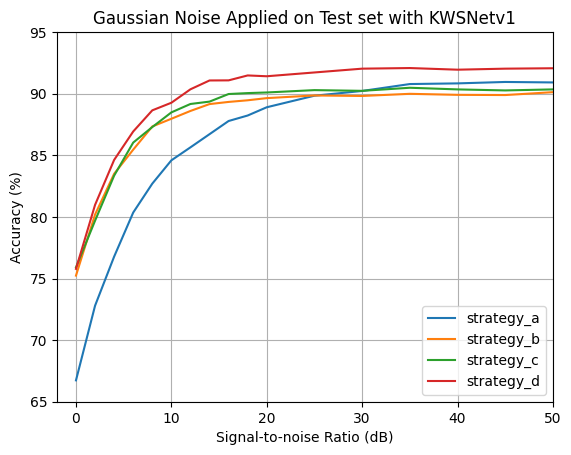

In [31]:
snr_db = np.array([0,2,4,6,8,10,12,14,16,18,20,25,30,35,40,45,50])
plt.plot(snr_db,accuracies[0], label = "strategy_a")
plt.plot(snr_db,accuracies[1], label = "strategy_b")
plt.plot(snr_db,accuracies[2], label = "strategy_c")
plt.plot(snr_db,accuracies[3], label = "strategy_d")
plt.title("Gaussian Noise Applied on Test set with KWSNetv1")
plt.xlim((-2, 50))
plt.ylim((65, 95))
plt.xlabel('Signal-to-noise Ratio (dB)')
plt.ylabel('Accuracy (%)')
plt.legend(loc="lower right")
plt.grid()